# Kaggle competition: Natural Language Processing with Disaster Tweets.




### Brief description of the problem and data

This project is to participate in the Kaggle learning competition to build an NLP model which does binary classification
over a data set of about 10,000 English language tweets which may or may not be describing disasters. This is a supervised learning problem. 

The data consist of a training data file train.csv (7613 rows) and a test data file test.csv (3263 rows)

The train.csv has the following columns:

* id -- an integer id for each sample tweet

* keyword -- a category for the tweet with 222 unique values, 61 missing

* location -- location name with 3341 unique values, 2533 missing

* text -- the text of the tweet

* target -- the 0/1 label for binary classification where 1 = disaster

The test.csv has the same first 4 columns but not the target value which we need to predict. The id is not significant for training, but is needed for the test data because we need to include it with the predictions submitted to Kaggle.

In the training set, the  two classes are not quite evenly balanced, but are close with 42.9% in the positive (disaster) class.




In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
## warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [2]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [3]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


### Exploratory Data Analysis (EDA) Data Cleaning and Preparation

The general plan is to build some type of binary classification recurrent neural network model on the sequence of words in the tweets. The assignment suggests using word embeddings. I chose to use GloVe pretrained embeddings from https://nlp.stanford.edu/projects/glove/ . In particular I picked the glove.6B.zip data set which has a 400K vocabulary extracted and trained from Wikipedia 2014 and Gigaword 5. This data set has a choice of 4 sets of word vectors of dimension 50, 100, 200, or 300.

This dataset provides a dictionary to look up word vectors from lower cased word tokens. So my strategy for cleaning the data is to lower case all the letters in the tweets, while discarding all punctuation, numbers, and anything else not alpha characters, then split the resulting string on blanks, to get work tokens. I will then look up each token in the GloVe dictionary, and skip any tokens that don't match a known word embedding.

In this process I found that some of the tweets had no useable words.  I could have skipped these samples for the training set, but they need to be preserved in the test set because we must provide a prediction for each of the test data in submitting to Kaggle. To treat the training and test data sets the same, I chose to substitute the single word "neutral" for any tweet that had no useable tokents.

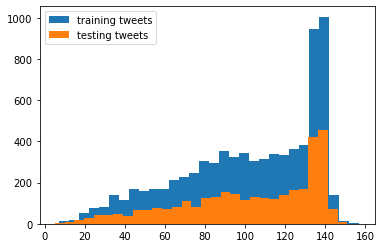

In [4]:
## We can get a quick look as the charater length distributions of the tweets in the test and training data sets

train_len=df_train['text'].str.len()
test_len=df_test['text'].str.len()
plt.hist(train_len, bins=30, label="training tweets")
plt.hist(test_len, bins=30, label="testing tweets")
plt.legend()
plt.show()

In [5]:
## Function to Load the GloVe dictionary of word embeddings.
## I experimented with word vectors of 50, 100, and 200 dimension from GloVe, but 100 seems to work best for this problem.

def get_glove_vectors(filename="data/glove.6B.100d.txt"):
    ## function from https://campus.datacamp.com/courses/recurrent-neural-networks-for-language-modeling-in-python/rnn-architecture?ex=7
    # Get all word vectors from pre-trained model
    glove_vector_dict = {}
    with open(filename, encoding="UTF-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = values[1:]
            glove_vector_dict[word] = np.asarray(coefs, dtype='float32')
    return glove_vector_dict

import time
start = time.time()

glove_vector_dict = get_glove_vectors()

end = time.time()
print(f'elapsed seconds = {end - start}')
type(glove_vector_dict)


elapsed seconds = 10.823406457901001


dict

I chose to ignore the Location column in the data and I added the keyword column as additional words at the end of each tweet.

At this point I have the train and test datasets in pandas data frames df_train and df_test, exactly as read from the CSV files. Initially I tried just discarding the keyword column. But I changed this to the simple approach of appending the keywords as additional words at the end of each tweet. The following code does this:

In [6]:
## Previous models ignored the keyword column in the training and test data.

## To incorporate the keyword, we will try just appending the keywords (when present) as
## an additional one or two tokens at the end of each tweet text.

## This function modifies the pandas dataframe df by
## appending the keyword (if present) to the end of the tweet.
## Keywords like 'airplane%20accident' are split into two words.
## It also writes the modified dataframe to a csv file (for debugging).
def add_keyword(df, filename=None):
    df.loc[df['keyword'].isna()==False,'text'] = df['text'] + ' ' + df['keyword'].str.replace('%20',' ')
    if filename:
        df.to_csv(f'data/{filename}',index=False)

add_keyword(df_train, filename='df_train.csv')
add_keyword(df_test, filename='df_test.csv')

Here is the raw text from a few example tweets:

In [7]:
list(df_train.loc[29:34,'text'])

['Do you like pasta?',
 'The end!',
 '@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C ablaze',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw ablaze',
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi ablaze',
 'Crying out for more! Set me ablaze ablaze']

In [8]:
s1 = df_train[df_train['id']==232]['text']
s1 = list(s1)[0]
s1

"+ Nicole Fletcher one of a victim of crashed airplane few times ago. \n\nThe accident left a little bit trauma for her. Although she's \n\n+ airplane accident"

Here we define a function to clean up the tweets by removing all non alpha characters, lower case the text, and split the string into word tokens on space.

In [9]:
import re

def clean_up_tweet(tweet):
    """
    Clean up the content of one tweet, removing punctuation and numbers. 
    
    Parameters:
    tweet(str):The text of the tweet
    
    Returns:
    word_list: A list of pure alphabetic words in lower case
    
    """
    ## Remove all characters execept alphabetic chars and space,
    ## convert to lower case and split on space.
    word_list = re.sub('[^A-Za-z ]+','',tweet).lower().split(' ')
    return word_list

In [10]:
## Same as the last example tweet after cleaning
clean_up_tweet(s1)

['',
 'nicole',
 'fletcher',
 'one',
 'of',
 'a',
 'victim',
 'of',
 'crashed',
 'airplane',
 'few',
 'times',
 'ago',
 'the',
 'accident',
 'left',
 'a',
 'little',
 'bit',
 'trauma',
 'for',
 'her',
 'although',
 'shes',
 '',
 'airplane',
 'accident']

In preparing the data for training, I want to reserve 20% for validation during training.

In [11]:
train, valid = train_test_split(df_train, train_size=0.8, shuffle=True, random_state=42)
print(train.shape)
print(valid.shape)

(6090, 5)
(1523, 5)


Here we are applying the clean_up_tweet function to produce clean lower case word tokens for each of 3 data sets for training, validation, and testing.

In [12]:
train_x = train['text'].map(clean_up_tweet)
valid_x = valid['text'].map(clean_up_tweet)
test_x = df_test['text'].map(clean_up_tweet)

print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)


(6090,)
(1523,)
(3263,)


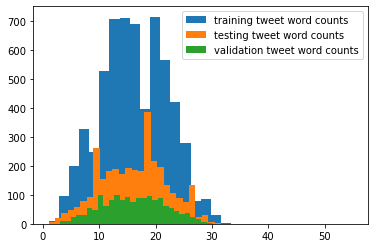

In [13]:
## Now that the tweets have been cleaned we can take a look at the
## distribution of tweet word counts, as 3 sets for training, validation, and testing

train_x_len = train_x.map(len)
valid_x_len = valid_x.map(len)
test_x_len = test_x.map(len)


plt.hist(train_x_len, bins=30, label="training tweet word counts")

plt.hist(test_x_len, bins=30, label="testing tweet word counts")

plt.hist(valid_x_len, bins=30, label="validation tweet word counts")

plt.legend()
plt.show()

Here we extract the target values for training and validation.

In [14]:
train_y = np.array(train['target'], dtype=np.float32)
valid_y = np.array(valid['target'], dtype=np.float32)
print(train_y[:5])
print(train_y[-5:])
print(np.sum(train_y)/len(train_y))
print(np.sum(valid_y)/len(valid_y))

[1. 0. 1. 1. 0.]
[0. 0. 0. 1. 1.]
0.43054187192118226
0.4261326329612607


Above we confirmed that the train and validation sets have about the same class proportions for the target.



Once we have a sequence of word vectors for each tweet, 
we will also need to pad each sequence to a uniform length before training with a recurrent NN model. 
The following code counts the words in each tweet and finds the max lengths. Based on these counts,
I chose to pad all the sequences to length 56, which covers all the tweets.

In [15]:
train['tweet_word_counts'] = [len(x) for x in train_x]
valid['tweet_word_counts'] = [len(x) for x in valid_x]
df_test['tweet_word_counts'] = [len(x) for x in test_x]
print(np.max(train['tweet_word_counts']) )
print(np.max(valid['tweet_word_counts']) )
print(np.max(df_test['tweet_word_counts']) )

55
31
35


Now we are ready to replace the cleaned word tokens in the tweets with word embeddings from the GloVe data set. I am using the 100d data file that has vectors of 100 floats for each word.

In [16]:
def glove_word_embeddings(word_lists, pad_to=56):
    ## We plan to replace all the words in the tweets
    ## with embeddings from the GloVe dictionary, skipping
    ## any words not found, and also padding the sequence 
    ## of embeddings to a fixed length.
    
    ## If none of the words match for a given tweet we will substitute
    ## a with place holder vector of one word, "neutral".
    d = glove_vector_dict
    neutral = d["neutral"]
    placeHolder = np.array([neutral])
    padNeutral = pad_sequences(placeHolder.T, pad_to, dtype='float32')
    outer = []
    for word_list in word_lists:
        enc_list = []
        for word in word_list:
            if(type(d.get(word)) is np.ndarray):
                enc_list.append(d.get(word))
        if(len(enc_list) > 0):
            enc_array = np.array(enc_list)
            pad = pad_sequences(enc_array.T, pad_to, dtype='float32')
            outer.append(pad.T)
        else:
            outer.append(padNeutral.T)
    return np.array(outer)

In [17]:

start = time.time()
X_train = glove_word_embeddings(train_x)
X_valid = glove_word_embeddings(valid_x)
X_test = glove_word_embeddings(test_x)
end = time.time()
print(f'elapsed seconds = {end - start}')
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

elapsed seconds = 2.32283878326416
(6090, 56, 100)
(1523, 56, 100)
(3263, 56, 100)


### Model Architecture

I tried the following model configurations. The details of the model definitions, training, and local validation results
appear below in this notebook. My github project has about 20 other notebooks which I saved during incremental model development
but a summary of all my work is shown here.

* Model 1 -- Single Layer LSTM, 128 units per layer

* Model 2 -- Two Layer LSTM, 128 units per layer

* Model 3 -- Three Layer LSTM, 128 units per layer

* Model 4 - Bi-Directional LSTM with 2 layers, 64 units per layer

* Model 5 - Bi-Directional LSTM with 3 layers, 64 units per layer

I used GloVe word embeddings for this project, tranforming the tweets into a sequence of embeddings for only those
tokens from the tweets which matched words in the Glove vocabulary.
Given a sequence of word embeddings from a large corpus, we would expect that an LSTM sequential model should be
able to pick up patterns in the word sequences to help with classifying the tweets as disaster or not.

### Results and Analysis 

I started with a single layer LSTM in Model 1. This model has an LSTM layer with 128 units, followed by
a Dense layer with 1 unit and Sigmoid activiation to do binary classification with appoximate probability estimates
of the positive (disaster) class as the single output.

With the Keras Sequential API it is easy to add additional layers of LSTM units,
which I did in Model 2 and Model 3. Adding the 2nd and third LSTM layer made small incremental improvements in F1 score, but the 3rd layer improvement was very minor. I tried adding a 4th layer, which hurt performance.

After Model 3, I switched to the BiDirectional LSTM configuration shown in Models 4 and 5. The performance of these models was not much different from Model 3 when trained and evaluated locally, but Model 5 gave me my best score for a Kaggle submission.

For all of the models I used Dropout in the range of 0.2 to 0.3 to reduce overfitting, and also used early stopping based on minimum validation loss, to know when to stop training. Other hyper parameter tuning included reducing the learning rate and reducing the number of units per LSTM layer, between my first and final models. This process could have been carried further, but tuning was only giving very small gains. I also tried switching to GRU models instead of LSTM otherwise keeping the same architecture. The GRU models train slightly faster, but did not give better performance than LSTM models.

### Conclusions

Using pretrained GloVe word embedding vectors, and fairly simple LSTM and BiDirectional LSTM models I was able to produce fairly reasonable, but not wonderful, predictions on this binary classification problem. Tweaking the model architecture and more hyperparameter tuning could lead to minor improvements, but I think a different approach would be needed for significant improvements.

Some possible improvements are:

* Using a GloVe data set with a larger vocabulary. The data set I used had about a 400k vocabulary, but there are larger Glove datasets available.

* I think sequences of word embeddings could be combined with additional sequences such as Part of Speech predictions and Named Entity Recognition using spaCy to produce a more powerful LSTM model for this type of problem.

One thing that worked well is that I was able to train models quickly. By using word embeddings pre-trained on a large corpus I avoided needing to train word embeddings from scratch. This disaster tweets data set was probably too small to do meaningful training from scratch, anyway.
Also I have my computer setup configured for GPU processing with tensorflow. As a result all of my models train in 10 seconds or less per epoch for this project.





# Model Details, Local training and validation code:

## Model 1 -- Single Layer LSTM, 128 units per layer

In [16]:
DROPOUT = 0.2
UNITS_PER_LAYER = 128

# Build model
model = Sequential()
model.add(LSTM(units=UNITS_PER_LAYER, input_shape=(None, 100), return_sequences=False, dropout=DROPOUT))
model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

file_name = 'weights_{epoch:03d}_{val_accuracy:.4f}.hdf5'

checkpoint_filepath = os.path.join('.', 'SAVE_MODELS', file_name)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 117,377
Trainable params: 117,377
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, train_y, 
                    batch_size=20, 
                    epochs=100, 
                    validation_data=(X_valid,valid_y),
                    callbacks=[earlyStopping,modelCheckpoint]
                   )

Epoch 1/100
305/305 [==============================] - 6s 11ms/step - loss: 0.4760 - accuracy: 0.7813 - val_loss: 0.4317 - val_accuracy: 0.8135
Epoch 2/100
305/305 [==============================] - 3s 10ms/step - loss: 0.4336 - accuracy: 0.8079 - val_loss: 0.4085 - val_accuracy: 0.8293
Epoch 3/100
305/305 [==============================] - 3s 10ms/step - loss: 0.4142 - accuracy: 0.8158 - val_loss: 0.4156 - val_accuracy: 0.8207
Epoch 4/100
305/305 [==============================] - 3s 10ms/step - loss: 0.3969 - accuracy: 0.8291 - val_loss: 0.4481 - val_accuracy: 0.7945
Epoch 5/100
305/305 [==============================] - 3s 10ms/step - loss: 0.3802 - accuracy: 0.8351 - val_loss: 0.4236 - val_accuracy: 0.8221
Epoch 6/100
305/305 [==============================] - 3s 10ms/step - loss: 0.3652 - accuracy: 0.8404 - val_loss: 0.4141 - val_accuracy: 0.8319
Epoch 7/100
305/305 [==============================] - 3s 10ms/step - loss: 0.3446 - accuracy: 0.8558 - val_loss: 0.4467 - val_accuracy:

In [18]:
sub_num = 18

predict_proba = model.predict(X_test,batch_size=20)
predict = (predict_proba > 0.5).astype(int)

submission = pd.DataFrame(df_test['id'])
submission['target']=predict

submission.to_csv(f'data/submission{sub_num}.csv',index=False)
submission

yp_proba = model.predict(X_valid, batch_size=20)
yp = (yp_proba > 0.5).astype(int)
print('acc', accuracy_score(valid_y, yp))
print('recall', recall_score(valid_y, yp))
print('precision', precision_score(valid_y, yp))
print('F1', f1_score(valid_y, yp))
pd.DataFrame(confusion_matrix(valid_y,yp))

77/77 [==============================] - 0s 3ms/step
acc 0.8292843072882469
recall 0.7442218798151001
precision 0.8370883882149047
F1 0.7879282218597063


,0,1
0,780,94
1,166,483


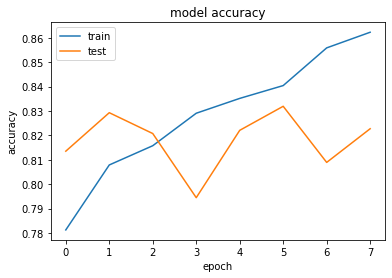

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 2 -- Two Layer LSTM, 128 units per layer

In [20]:
DROPOUT = 0.2
UNITS_PER_LAYER = 128

# Build model
model = Sequential()
model.add(LSTM(units=UNITS_PER_LAYER, input_shape=(None, 100), return_sequences=True, dropout=DROPOUT))
model.add(LSTM(units=UNITS_PER_LAYER, return_sequences=False, dropout=DROPOUT))
model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

file_name = 'weights_{epoch:03d}_{val_accuracy:.4f}.hdf5'

checkpoint_filepath = os.path.join('.', 'SAVE_MODELS', file_name)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 128)         117248    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 248,961
Trainable params: 248,961
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, train_y, 
                    batch_size=20, 
                    epochs=100, 
                    validation_data=(X_valid,valid_y),
                    callbacks=[earlyStopping,modelCheckpoint]
                   )

Epoch 1/100
305/305 [==============================] - 8s 18ms/step - loss: 0.4831 - accuracy: 0.7796 - val_loss: 0.4764 - val_accuracy: 0.8129
Epoch 2/100
305/305 [==============================] - 5s 16ms/step - loss: 0.4382 - accuracy: 0.8076 - val_loss: 0.4377 - val_accuracy: 0.8319
Epoch 3/100
305/305 [==============================] - 5s 16ms/step - loss: 0.4160 - accuracy: 0.8176 - val_loss: 0.4180 - val_accuracy: 0.8129
Epoch 4/100
305/305 [==============================] - 5s 16ms/step - loss: 0.3967 - accuracy: 0.8292 - val_loss: 0.4105 - val_accuracy: 0.8286
Epoch 5/100
305/305 [==============================] - 5s 16ms/step - loss: 0.3855 - accuracy: 0.8320 - val_loss: 0.4165 - val_accuracy: 0.8247
Epoch 6/100
305/305 [==============================] - 5s 16ms/step - loss: 0.3671 - accuracy: 0.8422 - val_loss: 0.4460 - val_accuracy: 0.8253
Epoch 7/100
305/305 [==============================] - 5s 15ms/step - loss: 0.3488 - accuracy: 0.8483 - val_loss: 0.4372 - val_accuracy:

In [22]:
sub_num = 18

predict_proba = model.predict(X_test,batch_size=20)
predict = (predict_proba > 0.5).astype(int)

submission = pd.DataFrame(df_test['id'])
submission['target']=predict

submission.to_csv(f'data/submission{sub_num}.csv',index=False)
submission

yp_proba = model.predict(X_valid, batch_size=20)
yp = (yp_proba > 0.5).astype(int)
print('acc', accuracy_score(valid_y, yp))
print('recall', recall_score(valid_y, yp))
print('precision', precision_score(valid_y, yp))
print('F1', f1_score(valid_y, yp))
pd.DataFrame(confusion_matrix(valid_y,yp))

77/77 [==============================] - 0s 6ms/step
acc 0.8286277084701248
recall 0.7211093990755008
precision 0.8540145985401459
F1 0.7819548872180451


,0,1
0,794,80
1,181,468


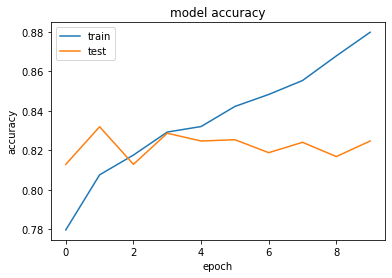

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 3 -- Three Layer LSTM, 128 units per layer

In [24]:
DROPOUT = 0.2
UNITS_PER_LAYER = 128

# Build model
model = Sequential()
model.add(LSTM(units=UNITS_PER_LAYER, input_shape=(None, 100), return_sequences=True, dropout=DROPOUT))
model.add(LSTM(units=UNITS_PER_LAYER, return_sequences=True, dropout=DROPOUT))
model.add(LSTM(units=UNITS_PER_LAYER, return_sequences=False, dropout=DROPOUT))
model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

file_name = 'weights_{epoch:03d}_{val_accuracy:.4f}.hdf5'

checkpoint_filepath = os.path.join('.', 'SAVE_MODELS', file_name)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 128)         117248    
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 380,545
Trainable params: 380,545
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train, train_y, 
                    batch_size=20, 
                    epochs=100, 
                    validation_data=(X_valid,valid_y),
                    callbacks=[earlyStopping,modelCheckpoint]
                   )

Epoch 1/100
305/305 [==============================] - 11s 25ms/step - loss: 0.4883 - accuracy: 0.7765 - val_loss: 0.4456 - val_accuracy: 0.8070
Epoch 2/100
305/305 [==============================] - 7s 21ms/step - loss: 0.4396 - accuracy: 0.8097 - val_loss: 0.4267 - val_accuracy: 0.8201
Epoch 3/100
305/305 [==============================] - 7s 21ms/step - loss: 0.4258 - accuracy: 0.8153 - val_loss: 0.4137 - val_accuracy: 0.8293
Epoch 4/100
305/305 [==============================] - 6s 21ms/step - loss: 0.4071 - accuracy: 0.8217 - val_loss: 0.4165 - val_accuracy: 0.8168
Epoch 5/100
305/305 [==============================] - 7s 22ms/step - loss: 0.3924 - accuracy: 0.8353 - val_loss: 0.4176 - val_accuracy: 0.8234
Epoch 6/100
305/305 [==============================] - 7s 22ms/step - loss: 0.3742 - accuracy: 0.8378 - val_loss: 0.4258 - val_accuracy: 0.8293
Epoch 7/100
305/305 [==============================] - 7s 21ms/step - loss: 0.3582 - accuracy: 0.8501 - val_loss: 0.4379 - val_accuracy

In [26]:
sub_num = 18

predict_proba = model.predict(X_test,batch_size=20)
predict = (predict_proba > 0.5).astype(int)

submission = pd.DataFrame(df_test['id'])
submission['target']=predict

submission.to_csv(f'data/submission{sub_num}.csv',index=False)
submission

yp_proba = model.predict(X_valid, batch_size=20)
yp = (yp_proba > 0.5).astype(int)
print('acc', accuracy_score(valid_y, yp))
print('recall', recall_score(valid_y, yp))
print('precision', precision_score(valid_y, yp))
print('F1', f1_score(valid_y, yp))
pd.DataFrame(confusion_matrix(valid_y,yp))

77/77 [==============================] - 1s 9ms/step
acc 0.8292843072882469
recall 0.7349768875192604
precision 0.8442477876106195
F1 0.785831960461285


,0,1
0,786,88
1,172,477


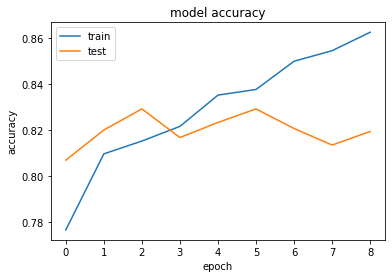

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 4 - Bi-Directional LSTM with 2 layers, 64 units per layer

In [28]:
DROPOUT = 0.2
UNITS_PER_LAYER = 64

## Try switching to a Bidirectional LSTM model, as in this example
## https://keras.io/examples/nlp/bidirectional_lstm_imdb/

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(None, 100) )
x = layers.Bidirectional(LSTM(units=UNITS_PER_LAYER, return_sequences=True, dropout=DROPOUT))(inputs)
x = layers.Bidirectional(LSTM(units=UNITS_PER_LAYER, return_sequences=False, dropout=DROPOUT))(x)
# Add a classifier
outputs = layers.Dense(1,  activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

file_name = 'weights_{epoch:03d}_{val_accuracy:.4f}.hdf5'

checkpoint_filepath = os.path.join('.', 'SAVE_MODELS', file_name)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 183,425
Trainable params: 183,425
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(X_train, train_y, 
                    batch_size=20, 
                    epochs=100, 
                    validation_data=(X_valid,valid_y),
                    callbacks=[earlyStopping,modelCheckpoint]
                   )

Epoch 1/100
305/305 [==============================] - 13s 27ms/step - loss: 0.4877 - accuracy: 0.7708 - val_loss: 0.4190 - val_accuracy: 0.8280
Epoch 2/100
305/305 [==============================] - 7s 22ms/step - loss: 0.4326 - accuracy: 0.8112 - val_loss: 0.4146 - val_accuracy: 0.8345
Epoch 3/100
305/305 [==============================] - 7s 22ms/step - loss: 0.4227 - accuracy: 0.8156 - val_loss: 0.4068 - val_accuracy: 0.8299
Epoch 4/100
305/305 [==============================] - 7s 22ms/step - loss: 0.4109 - accuracy: 0.8212 - val_loss: 0.4285 - val_accuracy: 0.8083
Epoch 5/100
305/305 [==============================] - 7s 22ms/step - loss: 0.4040 - accuracy: 0.8218 - val_loss: 0.4034 - val_accuracy: 0.8345
Epoch 6/100
305/305 [==============================] - 7s 22ms/step - loss: 0.3902 - accuracy: 0.8309 - val_loss: 0.4119 - val_accuracy: 0.8313
Epoch 7/100
305/305 [==============================] - 7s 22ms/step - loss: 0.3853 - accuracy: 0.8343 - val_loss: 0.4241 - val_accuracy

In [30]:
sub_num = 18

predict_proba = model.predict(X_test,batch_size=20)
predict = (predict_proba > 0.5).astype(int)

submission = pd.DataFrame(df_test['id'])
submission['target']=predict

submission.to_csv(f'data/submission{sub_num}.csv',index=False)
submission

yp_proba = model.predict(X_valid, batch_size=20)
yp = (yp_proba > 0.5).astype(int)
print('acc', accuracy_score(valid_y, yp))
print('recall', recall_score(valid_y, yp))
print('precision', precision_score(valid_y, yp))
print('F1', f1_score(valid_y, yp))
pd.DataFrame(confusion_matrix(valid_y,yp))

77/77 [==============================] - 1s 8ms/step
acc 0.8345370978332239
recall 0.724191063174114
precision 0.8655616942909761
F1 0.7885906040268456


,0,1
0,801,73
1,179,470


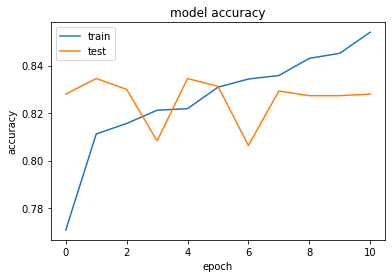

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 5  - Bi-Directional LSTM with 3 layers, 64 units per layer

In [32]:
DROPOUT = 0.2
UNITS_PER_LAYER = 64

## Try switching to a Bidirectional LSTM model, as in this example
## https://keras.io/examples/nlp/bidirectional_lstm_imdb/

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(None, 100) )
x = layers.Bidirectional(LSTM(units=UNITS_PER_LAYER, return_sequences=True, dropout=DROPOUT))(inputs)
x = layers.Bidirectional(LSTM(units=UNITS_PER_LAYER, return_sequences=True, dropout=DROPOUT))(x)
x = layers.Bidirectional(LSTM(units=UNITS_PER_LAYER, return_sequences=False, dropout=DROPOUT))(x)
# Add a classifier
outputs = layers.Dense(1,  activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

file_name = 'weights_{epoch:03d}_{val_accuracy:.4f}.hdf5'

checkpoint_filepath = os.path.join('.', 'SAVE_MODELS', file_name)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        84480     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                           

In [33]:
history = model.fit(X_train, train_y, 
                    batch_size=20, 
                    epochs=100, 
                    validation_data=(X_valid,valid_y),
                    callbacks=[earlyStopping,modelCheckpoint]
                   )

Epoch 1/100
305/305 [==============================] - 18s 38ms/step - loss: 0.4926 - accuracy: 0.7637 - val_loss: 0.4338 - val_accuracy: 0.8142
Epoch 2/100
305/305 [==============================] - 9s 31ms/step - loss: 0.4372 - accuracy: 0.8067 - val_loss: 0.4515 - val_accuracy: 0.8142
Epoch 3/100
305/305 [==============================] - 9s 31ms/step - loss: 0.4257 - accuracy: 0.8158 - val_loss: 0.4363 - val_accuracy: 0.8096
Epoch 4/100
305/305 [==============================] - 10s 31ms/step - loss: 0.4076 - accuracy: 0.8269 - val_loss: 0.4243 - val_accuracy: 0.8181
Epoch 5/100
305/305 [==============================] - 9s 31ms/step - loss: 0.4003 - accuracy: 0.8220 - val_loss: 0.4141 - val_accuracy: 0.8280
Epoch 6/100
305/305 [==============================] - 10s 31ms/step - loss: 0.3901 - accuracy: 0.8276 - val_loss: 0.4302 - val_accuracy: 0.8293
Epoch 7/100
305/305 [==============================] - 9s 31ms/step - loss: 0.3808 - accuracy: 0.8355 - val_loss: 0.4116 - val_accura

In [34]:
sub_num = 19

predict_proba = model.predict(X_test,batch_size=20)
predict = (predict_proba > 0.5).astype(int)

submission = pd.DataFrame(df_test['id'])
submission['target']=predict

submission.to_csv(f'data/submission{sub_num}.csv',index=False)
submission

yp_proba = model.predict(X_valid, batch_size=20)
yp = (yp_proba > 0.5).astype(int)
print('acc', accuracy_score(valid_y, yp))
print('recall', recall_score(valid_y, yp))
print('precision', precision_score(valid_y, yp))
print('F1', f1_score(valid_y, yp))
pd.DataFrame(confusion_matrix(valid_y,yp))

77/77 [==============================] - 1s 11ms/step
acc 0.8220617202889035
recall 0.7257318952234206
precision 0.8351063829787234
F1 0.7765869744435285


,0,1
0,781,93
1,178,471


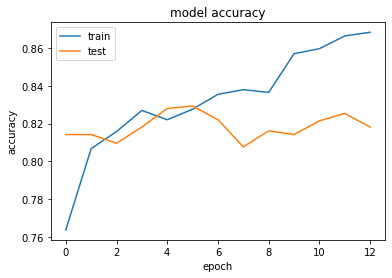

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### References

1) Kaggle Natural Language Processing with Disaster Tweets https://www.kaggle.com/competitions/nlp-getting-started/overview
    
2) GloVe: Global Vectors for Word Representation https://nlp.stanford.edu/projects/glove/

3) DataCamp Course: Recurrent Neural Networks for Language Modeling in Pythone: https://campus.datacamp.com/courses/recurrent-neural-networks-for-language-modeling-in-python

4) Keras.io example code for Bi-Directional LSTM model: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

5) Advanced Recurrent Neural Networks: Bidirectional RNNs https://blog.paperspace.com/bidirectional-rnn-keras/

6) Word Embeddings in Python with Spacy and Gensim https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/